In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

param_dict = {'spinewidth':2,
              'linewidth':4,
              'ticklength':6,
              'tickwidth':3,
              'ticklabelsize':20,
              'axislabelsize':20,
              'titlesize':25}
import matplotlib
def neaten_plot(neatenme, param_dict=param_dict):
    if isinstance(neatenme,matplotlib.figure.Figure):
        for ax in neatenme.axes:
            neaten_plot(ax)
        plt.tight_layout()
    elif isinstance(neatenme,matplotlib.axes.Axes):
        neatenme.tick_params(labelsize=param_dict['ticklabelsize'],length=param_dict['ticklength'],width=param_dict['tickwidth'])
        neatenme.xaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.yaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.title.set_fontsize(param_dict['titlesize'])
        for axis in ['top','bottom','left','right']:
            neatenme.spines[axis].set_linewidth(param_dict['spinewidth'])
        for line in neatenme.lines:
            line.set_linewidth(param_dict['linewidth'])

def plot_jungfrau(x,y,z,ax=None,shading='nearest',*args,**kwargs):
    if not ax:
        ax=plt.gca()
    for i in range(8):
        pcm = ax.pcolormesh(x[i],y[i],z[i],shading=shading,*args,**kwargs)
    return pcm

def createBinsFromCenters(centers):
    bins = []
    nc = centers.size
    for idx,c in enumerate(centers):
        if idx == 0:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c-dc)
            bins.append(c+dc)
        elif idx == nc-1:
            dc = np.abs( c - centers[idx-1])/2.
            bins.append(c+dc)
        else:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c+dc)
    return np.sort(np.array(bins))
            
def get_tree(f):
    """List the full tree of the h5 file"""
    def printname(name):  # needed because .visit needs callable
        print(name, type(f[name]))
    f.visit(printname)
    
def is_leaf(dataset):
    return isinstance(dataset,h5py.Dataset)

def get_leaves(f,saveto,verbose=False):
    def return_leaf(name):
        if is_leaf(f[name]):
            if verbose:
                print(name,f[name][()].shape)
            saveto[name] = f[name][()]
    f.visit(return_leaf)

def runNumToString(num):
    numstr = str(num)
    while len(numstr)<4:
        numstr = '0'+numstr
    return numstr

In [2]:
keys_to_combine = ['tt/FLTPOS',
                   'tt/AMPL',
                   'tt/FLTPOSFWHM',
                   'tt/ttCorr',
                   'tt/FLTPOS_PS',
                   'tt/AMPL',
                   'tt/AMPLNXT',
                   'tt/FLTPOS',
                   'tt/FLTPOS_PS',
                   'tt/REFAMPL',
                   #'scan/lxt_ttc',
                   'ipm_dg2/sum',
                   'ipm_dg3/sum',
                   'gas_detector/f_11_ENRC',
                   #'epicsAll/gasCell_pressure',
                   'jungfrau4M/azav_azav',
                   'evr/code_183',
                   'evr/code_162',
                   'evr/code_141',
                   #'epicsAll/gasCell_pressure',
                   'lightStatus/laser',
                   'lightStatus/xray',
                   # 'scan/var0',
                   #  'scan/LAS:FS5:MMS:PH',
                  ]
keys_to_sum = ['Sums/jungfrau4M_calib',
              'Sums/jungfrau4M_calib_thresADU1']
keys_to_check = ['UserDataCfg/jungfrau4M/azav__azav_q',
                'UserDataCfg/jungfrau4M/azav__azav_qbin',
                'UserDataCfg/jungfrau4M/azav__azav_qbins',
                'UserDataCfg/jungfrau4M/x',
                'UserDataCfg/jungfrau4M/y',
                'UserDataCfg/jungfrau4M/z',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_q',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_phi',
                'UserDataCfg/jungfrau4M/cmask',
                'UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU',
                'UserDataCfg/jungfrau4M/Full_thres__Full_thres_bound',
                'UserDataCfg/jungfrau4M/common_mode_pars']

def combineRuns(runNumbers,folder,verbose=False):
    data_array = []
    for i,runNumber in enumerate(runNumbers):
        data = {}
        filename = f'{folder}cxilx9320_Run{runNumToString(runNumber)}.h5'
        print(filename)
        with h5py.File(filename,'r') as f:
            get_leaves(f,data,verbose=verbose)
            data_array.append(data)
    hf1 = h5py.File(filename, 'r')
#    for key in hf1['epicsAll']:
#        print(key)
    data_combined = {}
    for key in keys_to_combine:
        arr = np.squeeze(data_array[0][key])
        for data in data_array[1:]:
            arr = np.concatenate((arr,np.squeeze(data[key])),axis=0)
        data_combined[key] = arr
    run_indicator = np.array([])
    for i,runNumber in enumerate(runNumbers):
        run_indicator = np.concatenate((run_indicator,runNumber*np.ones_like(data_array[i]['tt/FLTPOS'])))
    data_combined['run_indicator'] = run_indicator
    for key in keys_to_sum:
        arr = np.zeros_like(data_array[0][key])
        for data in data_array:
            arr += data[key]
        data_combined[key] = arr
    for key in keys_to_check:
        arr = data_array[0][key]
        for i,data in enumerate(data_array):
            if not np.array_equal(data[key],arr):
                print(f'Problem with key {key} in run {runNumbers[i]}')
        data_combined[key] = arr
    return data_combined

In [25]:
runNumbers = [7]
folder = '/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/'
data = combineRuns(runNumbers,folder=folder,verbose=False)

ttpos = data['tt/FLTPOS']
ttampl = data['tt/AMPL']
ttfwhm = data['tt/FLTPOSFWHM']
ttcorr = data['tt/ttCorr']
ttps = data['tt/FLTPOS_PS']
#scan = data['scan/LAS:FS5:MMS:PH']
#scan = data['scan/lxt_ttc']
#scan = data['scan/lxt']
q = data['UserDataCfg/jungfrau4M/azav__azav_q']
qbin = data['UserDataCfg/jungfrau4M/azav__azav_qbin']
qbins = data['UserDataCfg/jungfrau4M/azav__azav_qbins']
x = data['UserDataCfg/jungfrau4M/x']
y = data['UserDataCfg/jungfrau4M/y']
z = data['UserDataCfg/jungfrau4M/z']
matrix_q = data['UserDataCfg/jungfrau4M/azav__azav_matrix_q'].reshape(8,512,1024)
matrix_phi = data['UserDataCfg/jungfrau4M/azav__azav_matrix_phi'].reshape(8,512,1024)
dg2 = data['ipm_dg2/sum']
dg3 = data['ipm_dg3/sum']
#pressure = data['epicsAll/gasCell_pressure']
xray_energy = data['gas_detector/f_11_ENRC']
azav = np.squeeze(data['jungfrau4M/azav_azav'])
#pressure = data['epicsAll/gasCell_pressure']
laserOn = data['evr/code_183'].astype(bool)
xrayOn = data['evr/code_162'].astype(bool)
xray_even = data['evr/code_141'].astype(bool)
laserOn2 = data['lightStatus/laser'].astype(bool)
xrayOn2 = data['lightStatus/xray'].astype(bool)
jungfrau_sum = data['Sums/jungfrau4M_calib']
jungfrau_sum = data['Sums/jungfrau4M_calib_thresADU1']
jungfrau_sum[jungfrau_sum>100*np.median(jungfrau_sum)]=0
run_indicator = data['run_indicator']
cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool)
cmask1 = np.load('/reg/d/psdm/cxi/cxilx9320/results/Masks/Mask_Jungfrau_4_5_T_Edge.npy')
cmask_tot = cmask*cmask1
threshold = data['UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU']
cmpars = data['UserDataCfg/jungfrau4M/common_mode_pars']


/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0007.h5


In [26]:
print(np.sum(cmask1))
print(np.sum(cmask1)/(8*512*1024))

3907693.0
0.9316666126251221


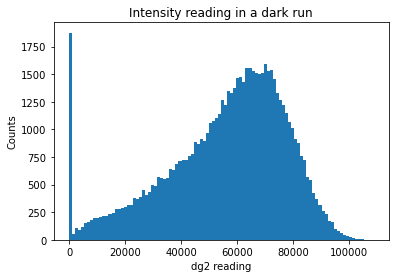

In [27]:
plt.figure()
plt.hist(dg2, bins = 100)
plt.xlabel('dg2 reading')
plt.ylabel('Counts')
plt.title('Intensity reading in a dark run')
plt.savefig('dg2_baseline.png')

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.42-py3/lib/python3.7/site-packages/ipykernel/__main__.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


(8, 512, 1024)


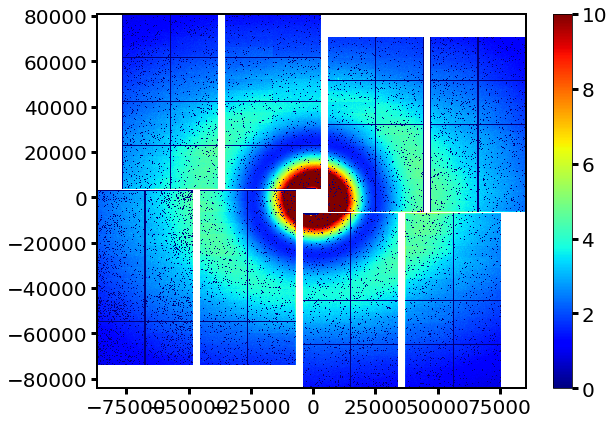

In [29]:
Plotting_Image = matrix_q*jungfrau_sum/azav[:,0].size
plt.figure(figsize=(9,6))
pcm = plot_jungfrau(-y,x,cmask_tot*Plotting_Image,vmin = np.min(Plotting_Image), vmax = 10, cmap = 'jet') # For SF6, higher scattering magnitude
# pcm = plot_jungfrau(-y,x,jungfrau_sum,vmax=100) # For bkg, adjust the value at your own judgement
plt.colorbar(pcm)
neaten_plot(plt.gcf())

print(jungfrau_sum.shape)

In [30]:
np.save('run_7_Jungfrau.npy', jungfrau_sum)
print(jungfrau_sum.shape)

(8, 512, 1024)


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.42-py3/lib/python3.7/site-packages/ipykernel/__main__.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


56698
9450


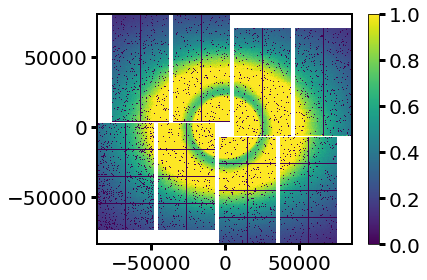

In [31]:
mask0 = cmask_tot
#instrument_response = np.load('/reg/d/psdm/cxi/cxilx9320/results/Instrument_Response/IRF_Ne_run6.npy')
instrument_response = np.ones((8,512,1024))

jungfrau_sum *= np.nan_to_num(mask0)
jungfrau_sum *= np.nan_to_num(instrument_response)

onshots = np.where(laserOn == True)[0]
offshots = np.where(laserOn == False)[0]
uvonshots = onshots.size
uvoffshots = offshots.size

jungfrau_sum /= (uvonshots + uvoffshots)

pcm = plot_jungfrau(-y,x,jungfrau_sum,vmax=1)
# pcm = plot_jungfrau(-y,x,jungfrau_sum,vmax=1e-2)
plt.colorbar(pcm)
neaten_plot(plt.gcf())

print(uvonshots)
print(uvoffshots)

In [33]:
from radavg import RadialAverager
x0, y0, z0, phi0 =  -351.82088112819076, -656.7823409052512, 83123.63347324678, 1.86406102e-2

wavelength = 0.77 #angstrom
X = x + x0
Y = y + y0
rr = np.sqrt((x)**2 + (y)**2) 
theta = np.arctan2(rr, z0) / 2.0
q = 4. * np.pi * np.sin(theta) / wavelength 
phi = np.arctan2((Y), (X)) + phi0 

nbins0 = 35 # ~0.05 inverse angstrom per bin

ra = RadialAverager(q, mask=mask0, n_bins=nbins0)
q_bins = ra.bin_centers
cmap = 'jet'
print('done')
print(q_bins[1]-q_bins[0])

done
0.20085805459036754


In [16]:
theory_pattern = np.load('SF6_Debye_Total.npy') # change the path to your own theoretical patterns
q_theory = theory_pattern[:,0]
polarization = np.sin(phi)**2 + np.cos(phi)**2*np.cos(2*theta)**2 #shape Jungfrau
geometry = np.cos(2*theta)**3 #shape Jungfrau
pol_average = ra(polarization) #shape qbins
geo_average = ra(geometry) #shape qbins
pol_correction = np.interp(q_theory,q_bins,pol_average) #goes from shape qbins to shape theory
geo_correction = np.interp(q_theory, q_bins, geo_average) #goes from shape qbins to shape theory
print('done')

done


# For SF6

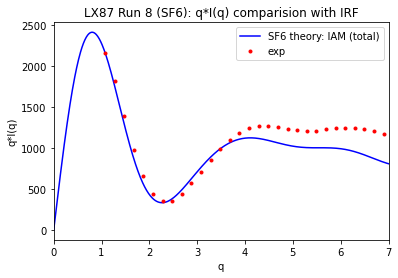

In [37]:
molecule = 'SF6'
#scale = 0.0035
scale = 0.006
theory = np.load('SF6_Debye_Total.npy') # change the path to your own theoretical patterns
q_theory = theory[:, 0]
scattering_theory = theory[:, 1]

exp_pattern_unscaled = ra(jungfrau_sum)/(pol_average*geo_average)
#exp_pattern_unscaled = ra(jungfrau_sum)
exp_pattern = exp_pattern_unscaled/scale

plt.plot(q_theory, q_theory*scattering_theory, color = 'blue', label = '%s theory: IAM (total)' % molecule) # 
plt.plot(q_bins[3:], q_bins[3:]*exp_pattern[3:], '.',color = 'red', label = 'exp') # ra(uvoffs1)/(pol_average*geo_average*scale) 
plt.xlabel('q')
plt.ylabel('q*I(q)')
plt.xlim([0, 7])
plt.title('LX87 Run 8 (SF6): q*I(q) comparision with IRF')
plt.legend()
plt.show()

# For 2-bromothiophene

In [19]:
molecule = '2-bromothiophene'
scale = 0.000025
theory = np.load('%s_Debye_Total.npy' % molecule) # change the path to your own theoretical patterns
q_theory = theory[:, 0]
scattering_theory = theory[:, 1]


#exp_pattern_unscaled = ra(jungfrau_sum)/(pol_average*geo_average)
exp_pattern_unscaled = exp_azav/(pol_average*geo_average)
exp_pattern = exp_pattern_unscaled/scale

plt.plot(q_theory, q_theory*scattering_theory, color = 'green', label = '%s theory: IAM' % molecule) # 
#plt.plot(q_bins[3:-2], (exp_pattern[3:-2]), '.',color = 'red', label = 'exp') # ra(uvoffs1)/(pol_average*geo_average*scale) 
plt.plot(qbins[:-1], qbins[:-1]*uvoffs_radial/scale, color = 'red', label = 'laser off')
plt.plot(qbins[:-1], qbins[:-1]*uvons_radial/scale, color = 'blue', label = 'laser on')
plt.xlabel('q')
plt.ylabel('q*I(q)')
# plt.ylabel('I(q)')
plt.xlim([0, 7])
#plt.ylim([0,7])
plt.title('LX87 Run 11 (NB): q*I(q) Pattern')
plt.legend()
plt.show()

NameError: name 'exp_azav' is not defined

# For 2-iodothiophene

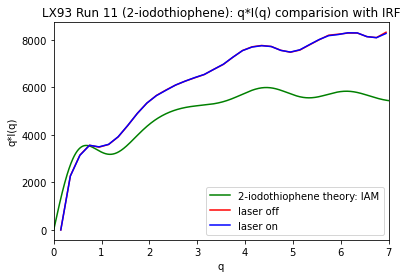

In [136]:
molecule = '2-iodothiophene'
scale = 0.00009
theory = np.load('%s_Debye_Total.npy' % molecule) # change the path to your own theoretical patterns
q_theory = theory[:, 0]
scattering_theory = theory[:, 1]

#exp_pattern_unscaled = ra(jungfrau_sum)/(pol_average*geo_average)
#exp_pattern = exp_pattern_unscaled/scale

plt.plot(q_theory, q_theory*scattering_theory, color = 'green', label = '%s theory: IAM' % molecule) # 
#plt.plot(q_bins[3:-2], q_bins[3:-2]* (exp_pattern[3:-2]), '.',color = 'red', label = 'exp') # ra(uvoffs1)/(pol_average*geo_average*scale)
#plt.plot(qbins[:-1], exp_pattern, '.',color = 'red', label = 'exp')
plt.plot(qbins[:-1], qbins[:-1]*uvoffs_radial/scale, color = 'red', label = 'laser off')
plt.plot(qbins[:-1], qbins[:-1]*uvons_radial/scale, color = 'blue', label = 'laser on')
plt.xlabel('q')
plt.ylabel('q*I(q)')
# plt.ylabel('I(q)')
plt.xlim([0, 7])
#plt.ylim([0,7])
plt.title('LX93 Run 11 (%s): q*I(q) comparision with IRF' % molecule)
plt.legend()
plt.show()

# For Neon

In [ ]:
molecule = 'Neon'
scale = 0.0036
theory_pattern = np.transpose(np.loadtxt('Ne_total.txt')) # change the path to your own theoretical patterns
q_theory = theory_pattern[:,0]
scattering_theory = theory_pattern[:,1]

exp_pattern_unscaled = ra(jungfrau_sum)/(pol_average*geo_average)
exp_pattern = exp_pattern_unscaled/scale

plt.figure()
plt.plot(q_theory, q_theory*scattering_theory, '-',color = 'blue', label = '%s theory Ab initio' % molecule) # 
plt.plot(q_bins[3:-3],  q_bins[3:-3]*exp_pattern[3:-3],'.', color = 'red', label = 'exp') #  
plt.xlabel('q')
plt.ylabel('q*I(q)')
plt.xlim([0 ,7])
plt.legend()
plt.title('LX87 Run 10 (Neon): q*I(q) comparision with IRF')
plt.show()

## Uvons and Uvoffs from azav

In [230]:
from scipy.interpolate import InterpolatedUnivariateSpline
onshots = np.where((laserOn == True) & (dg2 > 2000))[0]
offshots = np.where((laserOn == False) & (dg2 > 2000))[0]
uvonshots = onshots.size
uvoffshots = offshots.size
print(uvonshots)
print(uvoffshots)
Intensity_Average = np.average(np.nan_to_num(dg2))
print(Intensity_Average)
dg2_on = np.reshape(np.repeat(dg2[onshots], azav[0,:].size), (onshots.size, azav[0,:].size))
dg2_off = np.reshape(np.repeat(dg2[offshots], azav[0,:].size), (offshots.size, azav[0,:].size))
uvoffs_radial = (azav[offshots,:]*Intensity_Average/dg2_off).sum(axis=0)
uvoffs_radial = np.nan_to_num(uvoffs_radial/uvoffshots) 
uvons_radial = (azav[onshots,:]*Intensity_Average/dg2_on).sum(axis=0)
uvons_radial = np.nan_to_num(uvons_radial/uvonshots)
uvoffs_spline = InterpolatedUnivariateSpline(qbins[0:qbins.size - 1],uvoffs_radial)
uvoffs1 = uvoffs_spline(matrix_q)
uvons_spline = InterpolatedUnivariateSpline(qbins[0:qbins.size - 1], uvons_radial)
uvons1 = uvons_spline(matrix_q)
mask0 = np.ones((8,512,1024))
instrument_response = np.ones((8,512,1024))
#mask0 = np.load('/cds/data/psdm/cxi/cxilw1118/results/masks/Mask_Jungfrau_8_7.npy') # path of mask to be applied
#instrument_response = np.load('/cds/data/psdm/cxi/cxilw1118/results/instrument_response/Instrument_Response_Function_Ne_run11.npy') # path of IRF to be applied

# uvons1 is the laser on-shots total intensity    
uvons1 *= np.nan_to_num(mask0)
uvons1 *= np.nan_to_num(instrument_response)
#uvons1 /= uvonshots1  #averaged by number of laser on shots
print('task complete') # prints "task complete" when this part/box of script gets completed

36046
6009
54972.03008977031
task complete


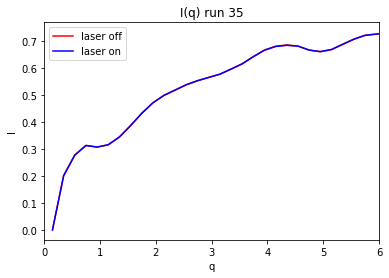

In [188]:
nbins0 = 60
ra = RadialAverager(matrix_q, mask=mask0, n_bins=nbins0)
q_bins = ra.bin_centers[:-1]

plt.figure()
#plt.plot(q_bins, ra(uvoffs1)[:-1], color = 'red') 
plt.plot(qbins[:-1], qbins[:-1]**1*uvoffs_radial, color = 'red', label = 'laser off')
plt.plot(qbins[:-1], qbins[:-1]**1*uvons_radial, color = 'blue', label = 'laser on')
plt.xlabel('q')
plt.ylabel('I')
plt.legend()
plt.title('I(q) run %d' % runNumbers[0])
#plt.title('I(q) run %d to %d' %(runs[0], runs[len(runs) - 1]))

plt.xlim([0,6])
plt.show()

#plt.savefig('run%d_to_%d_radial_average.png' % (runs[0], runs[len(runs) - 1]))


## Percent Difference Pattern

(2, 100)


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.42-py3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


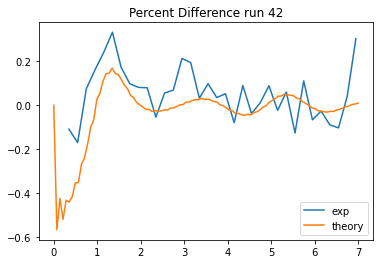

In [231]:
percent_difference = 100*(uvons_radial - uvoffs_radial)/uvoffs_radial
theory_perdiff = np.load('iodothiophene_diffsig.npy')
print(theory_perdiff.shape)
plt.figure()
plt.plot(qbins[:-1], percent_difference, label = 'exp')
plt.plot(theory_perdiff[0,:], theory_perdiff[1,:], label = 'theory')
plt.legend()
plt.title('Percent Difference run %d' % runNumbers[0])
#plt.show()
plt.savefig('run%d.png' % runNumbers[0])
np.save('run%d_perdiff.npy' % runNumbers[0], percent_difference)

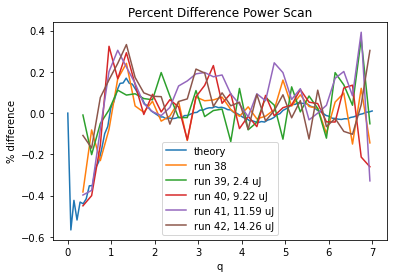

In [233]:
run38 = np.load('run38_perdiff.npy')
run39 = np.load('run39_perdiff.npy')
run40 = np.load('run40_perdiff.npy')
run41 = np.load('run41_perdiff.npy')
run42 = np.load('run42_perdiff.npy')

plt.figure()
plt.plot(theory_perdiff[0,:], theory_perdiff[1,:], label = 'theory')
plt.plot(qbins[:-1], run38, label = 'run 38')
plt.plot(qbins[:-1], run39, label = 'run 39, 2.4 uJ')
plt.plot(qbins[:-1], run40, label = 'run 40, 9.22 uJ')
plt.plot(qbins[:-1], run41, label = 'run 41, 11.59 uJ')
plt.plot(qbins[:-1], run42, label = 'run 42, 14.26 uJ')
plt.legend()
plt.title('Percent Difference Power Scan')
plt.xlabel('q')
plt.ylabel('% difference')
#plt.show()
plt.savefig('run%d.png' % runNumbers[0])
np.save('run%d_perdiff.npy' % runNumbers[0], percent_difference)